# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code).

The output of this notebook will be a pandas `DataFrame` with six columns:
- `episode`: An identifier for each ICU admission
- `timestep`: A `DateTime` object specifying the exact time (`charttime`) a measurement was recorded
- `x0`\*: An identifier specifying the type of measurement recorded at this timestep, e.g., a vital, such as `HeartRate`; a lab result, such as `Albumin` levels; or a treatment parameter, like `total_iv_fluid`.
- `x1`\*: The value of the actual measurement in the appropriate unit (e.g. ml, bmp, mmHg)
- `reward`: Reward accrued at each decision point (`NaN` if not a decision point)
- `action`: Action taken at each decision point (`NaN` if not a decision point)

\* we use the `x*` notation for this state space to allow us to use the eaxact same training scripts for Q-learning also for the transformer encoder.

Measurements in the dataset are primarily timestamped point measurements (see EDA), that is *values recorded at specific times*; however, **vasopressor** and **IV fluid intake** are recorded in terms of `(starttime, endtime)` intervals. As these treatments are actions in our **action space**, we sample them every 4 hours much like Roggeveen et al., allowing direct comparison of actions taken at the same points in time.

**Important**: Make sure to run the `MIMIC-III_preprocessing_roggeveen.ipynb` notebook first, as the trainval/test split is made there and reused to create an identical dataset split here.

In [1]:
# Dependencies
import os
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Directory where dataset is stored
DATA_DIR = '../data/mimic-iii/final/'

# We will be reusing the train/valid/test split and action space made previously
OUTPUT_DIR_ROGGEVEEN = 'datasets/mimic-iii/roggeveen_4h/'

# Directory where preprocessed data will be stored
OUTPUT_DIR = 'datasets/mimic-iii/attention/'

# Aggregation interval
INTERVAL_TIME = '4H'

In [2]:
# Check whether previous notbooks have been run and data is stored in right location
if not os.path.exists(OUTPUT_DIR_ROGGEVEEN):
    raise Exception('Cannot find %s. Please run `MIMIC-III_preprocessing_roggeveen.ipynb`.' % OUTPUT_DIR_ROGGEVEEN)

if not os.path.exists(DATA_DIR):
    raise Exception('Dataset directory %s does not exist!' % DATA_DIR)

# Create output_dir if not yet created
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

### Convenience functions

In [3]:
# Read CSV from file and parse dates using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    # Explicit as parse_dates param of pd.read_csv fails to identify starttime and endtime
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# Plots values of under `key` over time
def plot_single(df, item_id, title='', xlabel='Timestep', ylabel='Value', style='.-'):
    # Randomly choose icustay_id with data for item_id
    icustay_id = None
    while icustay_id is None:
        icustay_id = random.choice(list(set(df['episode'])))
        num_values = (df[(df['x0'] == item_id) & (df['episode'] == icustay_id)]['x1'] != 0).sum()
        icustay_id = None if num_values == 0 else icustay_id
        
    # Limit to item_id and chosen icustay_id
    df = df[(df['x0'] == item_id) & (df['episode'] == icustay_id)]
        
    plt.figure(figsize=(8, 3))
    plt.plot(df['timestep'], df['x1'], style)
    plt.title('%s (icustay_id=%d)' % (title, icustay_id))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

# Converts TimeDelta objects into hours
def to_hours(x):
    # pd.Timedelta does not have astype method
    if isinstance(x, pd.Timedelta):
        return x.total_seconds() / 3600
    return x.astype('timedelta64[s]').astype(int) / 3600

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()
    
print('HeartRate => %s' % to_snakecase('HeartRate'))
print('ALBUMIN   => %s' % to_snakecase('ALBUMIN'))
print('MeanBP    => %s' % to_snakecase('MeanBP'))

HeartRate => heart_rate
ALBUMIN   => albumin
MeanBP    => mean_bp


---
## Patient Cohort

Using MIMIC-Code we have extracted a *sepsis-3* cohort (i.e. a list of patients satisfying the sepsis-3 criteria (Singer et al., 2016)) along with information regarding the suspected time of infection and in-hospital mortality, `hospital_expire_flag`. Let's first import these data;

In [4]:
# Windows of 72h are stored in cohort.csv
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
print('Number of admissions:', len(cohort_df))
cohort_df.head()

Number of admissions: 18346


,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,55597,189080,226090,2122-04-13 22:38:32,2122-04-14 18:26:03,2122-04-13 21:35:00,2122-04-12 21:35:00,2122-04-15 21:35:00,0
1,6645,177907,205861,2105-07-11 21:28:35,2105-07-13 17:13:43,2105-07-11 00:00:00,2105-07-10 00:00:00,2105-07-13 00:00:00,0
2,30496,165002,281987,2194-06-18 14:03:07,2194-06-19 21:35:23,2194-06-18 00:00:00,2194-06-17 00:00:00,2194-06-20 00:00:00,0
3,92531,184997,218267,2171-07-10 15:10:29,2171-07-11 14:20:11,2171-07-10 11:40:00,2171-07-09 11:40:00,2171-07-12 11:40:00,0
4,28677,159991,282170,2122-12-31 09:28:43,2123-01-01 21:25:41,2122-12-31 18:25:00,2122-12-30 18:25:00,2123-01-02 18:25:00,0


**Sanity check: limit admissions to SOFA $\geq$ 2**

In [5]:
# Remark: The original notebook uses SOFA>3, yet the paper mentions the standard SOFA>=2 as the selection criterion
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')
sofa2_icustays = set([row['icustay_id'] for _, row in demo_df.iterrows() if row['sofa'] >= 2])

# Filter cohort
cohort_df = cohort_df[cohort_df['icustay_id'].isin(sofa2_icustays)]

In [6]:
icustay_ids = cohort_df['icustay_id'].values
print('Total number of admissions: %s' % icustay_ids.size) # few are dropped still

Total number of admissions: 18091


---
## $x$-Hour Intervals for Sampling of Vasopressor/Fluid Intake

In [7]:
def get_time_intervals(starttime, endtime):
    timesteps = pd.date_range(start=starttime, end=endtime, freq=INTERVAL_TIME)
    return list(zip(timesteps[:-1], timesteps[1:]))

# For each interval `(window_start, window_end)` generate list of (start, end) sub-intervals of each 1 hour
interval_times = {x['icustay_id']:get_time_intervals(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

In [8]:
# Sample random ICU stay
icustay_id = random.choice(list(interval_times.keys()))

print('Intervals for ICUSTAY %s:' % icustay_id)
print('1st Interval: ', interval_times[icustay_id][0])
print('Last Interval:', interval_times[icustay_id][-1])

Intervals for ICUSTAY 258075:
1st Interval:  (Timestamp('2160-12-23 17:30:00', freq='4H'), Timestamp('2160-12-23 21:30:00', freq='4H'))
Last Interval: (Timestamp('2160-12-26 13:30:00', freq='4H'), Timestamp('2160-12-26 17:30:00', freq='4H'))


---
## Vasopressors

### 1. Resampling MetaVision records in intervals of 4h

In [9]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,200063,2141-03-21 11:00:00,2141-03-21 14:14:00,0.312876,mcg/kg/min,131.8,8935976,8935976,norepinephrine,0.312876,41.237116
1,200063,2141-03-21 14:14:00,2141-03-21 14:41:00,0.300485,mcg/kg/min,131.8,5139193,5139193,norepinephrine,0.300485,39.603961
2,200063,2141-03-21 14:41:00,2141-03-21 15:00:00,0.401104,mcg/kg/min,131.8,8037665,5139193,norepinephrine,0.401104,52.865445
3,200063,2141-03-21 15:00:00,2141-03-21 15:27:00,0.301501,mcg/kg/min,131.8,6825847,5139193,norepinephrine,0.301501,39.737781
4,200063,2141-03-21 15:27:00,2141-03-21 18:27:00,0.200936,mcg/kg/min,131.8,5209279,5139193,norepinephrine,0.200936,26.483338


In [10]:
# Store sampled dfs in list
sampled_vaso_mv_dfs = []

for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Part of sepsis-3 cohort?
    if icustay_id not in interval_times:
        continue
        
    # Empty vector to store max_vaso values into
    intervals = interval_times[icustay_id]
    max_vaso = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):        
        # Inclusion test: treatment timeframe overlaps with current interval.
        # NOTE: original R-code erroneously used `endtime < interval_end`
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Max vasopressor dose administered in interval
        max_vaso[i] = treatments[condition]['mcgkgmin'].max() # Why max?
        
    # Create DataFrame for ICU stay
    sampled_vaso_mv_df = pd.DataFrame({'timestep': [end for _, end in intervals],
                                       'episode': icustay_id,
                                       'x0': 'max_vaso',
                                       'x1': np.nan_to_num(max_vaso, nan=0.0)}) # NaN (no treatment) -> zero dose
    sampled_vaso_mv_dfs.append(sampled_vaso_mv_df)
    
# Concat DataFrames of individual icustays
sampled_vaso_mv_df = pd.concat(sampled_vaso_mv_dfs)
sampled_vaso_mv_df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 4137/4137 [01:01<00:00, 67.76it/s]


,timestep,episode,x0,x1
0,2141-03-09 11:36:00,200063,max_vaso,0.0
1,2141-03-09 15:36:00,200063,max_vaso,0.0
2,2141-03-09 19:36:00,200063,max_vaso,0.0
3,2141-03-09 23:36:00,200063,max_vaso,0.0
4,2141-03-10 03:36:00,200063,max_vaso,0.0


In [11]:
del vaso_mv_df

#### Sanity check

In [12]:
# Many many ICU stays have records from MetaVision
num_mv_max_vaso_samples = len(sampled_vaso_mv_df['episode'].unique())
print('MetaVision max_vaso records: %s' % num_mv_max_vaso_samples)

MetaVision max_vaso records: 4131


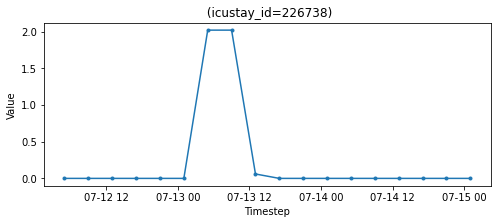

In [13]:
# Example trajectory
plot_single(sampled_vaso_mv_df, item_id='max_vaso')

---
## IV Fluids

### 1. Resampling MetaVision records in intervals of 4h

In [14]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Sanity check: remove amounts outside (0, 5000) range
condition = (ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = (ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

# Drop many useless columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
2,23,124321,234044.0,2157-10-21 15:00:00,2157-10-21 15:01:00,200.000000,0.016667
4,23,124321,234044.0,2157-10-21 12:15:00,2157-10-21 13:22:00,13.432238,1.116667
7,23,124321,234044.0,2157-10-21 17:08:00,2157-10-21 18:08:00,49.999999,1.000000
10,23,124321,234044.0,2157-10-22 08:00:00,2157-10-22 08:01:00,200.000000,0.016667
14,23,124321,234044.0,2157-10-22 09:24:00,2157-10-22 09:48:00,1.602968,0.400000


In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [15]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments['starttime']
    dose_end = treatments['endtime']
    amount = treatments['amount']
    duration = treatments['duration']
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()

    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    # Reamrk: Extra division by duration
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end > interval_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    # Return value if there was IV intake, else NaN
    return total_ml if total_ml > 0 else np.NaN

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [16]:
# Store sampled dfs in list
sampled_ivfluid_mv_dfs = []

print('Grab some coffee!\n')

for icustay_id, treatments in tqdm(ivfluid_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in interval_times:
        continue
    
    # Total fluid intake
    intervals = interval_times[icustay_id]
    total_ivfluid = np.zeros(len(intervals), dtype=np.float64)
    
    # Compute total IV fluid within each interval
    for i, (interval_start, interval_end) in enumerate(intervals):
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
                
    # Create DataFrame
    sampled_ivfluid_df = pd.DataFrame({'episode': icustay_id,
                                       'timestep': [end for _, end in intervals],
                                       'x0': 'total_iv_fluid',
                                       'x1': np.nan_to_num(total_ivfluid, nan=0.0)}) # NaN = 0
    sampled_ivfluid_mv_dfs.append(sampled_ivfluid_df)
    
# Concat DataFrames of individual icustays
sampled_ivfluid_mv_df = pd.concat(sampled_ivfluid_mv_dfs)
sampled_ivfluid_mv_df.head()

Grab some coffee!



100%|████████████████████████████████████████████████████████████████████████████| 13593/13593 [09:14<00:00, 24.54it/s]


,episode,timestep,x0,x1
0,200035.0,2156-10-06 20:50:00,total_iv_fluid,0.0
1,200035.0,2156-10-07 00:50:00,total_iv_fluid,0.0
2,200035.0,2156-10-07 04:50:00,total_iv_fluid,0.0
3,200035.0,2156-10-07 08:50:00,total_iv_fluid,0.0
4,200035.0,2156-10-07 12:50:00,total_iv_fluid,0.0


In [17]:
del ivfluid_mv_df

#### Visual check

In [18]:
# Many many ICU stays have records from MetaVision
num_mv_iv_fluid_samples = len(sampled_ivfluid_mv_df['episode'].unique())
print('MetaVision iv_fluid records: %s' % num_mv_iv_fluid_samples)

MetaVision iv_fluid records: 9203


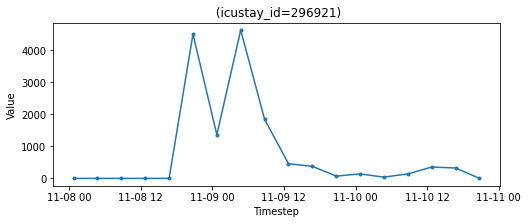

In [19]:
# Get total IV fluid intake for one random patient
plot_single(sampled_ivfluid_mv_df, item_id='total_iv_fluid')

#### **Problem**: Resampling CareVue records
Cannot be done as no end-of-interval points can be derived

---
## Vitals

Vitals are already in the correct general formal, therefore we only need to rename the columns, drop unnecessary ones and snake-case the `item_ids`;

In [20]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')

# Simply rename columns (vitals_df is already in the right format)
new_vitals_df = pd.DataFrame({'episode': vitals_df['icustay_id'],
                              'timestep': vitals_df['charttime'],
                              'x0': vitals_df['vital_id'].apply(to_snakecase),
                              'x1': vitals_df['valuenum']})
new_vitals_df.head()

,episode,timestep,x0,x1
0,294638,2191-03-16 01:30:00,heart_rate,111.000000
1,294638,2191-03-16 01:30:00,sp_o2,98.000000
2,294638,2191-03-16 01:30:00,temp_c,37.444445
3,294638,2191-03-16 02:00:00,dias_bp,63.000000
4,294638,2191-03-16 02:00:00,heart_rate,100.000000


In [21]:
del vitals_df

---
## Lab Results

In [22]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop NaNs in lab_id column
lab_df = lab_df[lab_df['lab_id'].notna()]

# Simply rename columns (lab_df is already in the right format)
new_lab_df = pd.DataFrame({'episode': lab_df['icustay_id'],
                           'timestep': lab_df['charttime'],
                           'x0': lab_df['lab_id'].apply(to_snakecase),
                           'x1': lab_df['valuenum']})
new_lab_df.head()

,episode,timestep,x0,x1
0,294638,2191-03-15 14:12:00,alat,28.0
1,294638,2191-03-15 14:12:00,anion gap,17.0
2,294638,2191-03-15 14:12:00,asat,69.0
3,294638,2191-03-15 14:12:00,bicarbonate,24.0
4,294638,2191-03-15 14:12:00,bilirubin,2.2


In [23]:
del lab_df

---
## FiO2 (Fraction of Inspired Oxygen)

In [24]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')

new_fio2_df = pd.DataFrame({'episode': fio2_df['icustay_id'],
                            'timestep': fio2_df['charttime'],
                            'x0': 'fi_o2',
                            'x1': fio2_df['fio2']})
new_fio2_df.head()

,episode,timestep,x0,x1
0,294638,2191-03-16 03:00:00,fi_o2,94.999999
1,294638,2191-03-16 08:00:00,fi_o2,50.000000
2,294638,2191-03-16 11:00:00,fi_o2,NaN
3,220597,2149-11-09 13:40:00,fi_o2,NaN
4,220597,2149-11-09 17:00:00,fi_o2,60.000002


In [25]:
del fio2_df

---
## Urine Output

In [26]:
urineoutput_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

new_urineoutput_df = pd.DataFrame({'episode': urineoutput_df['icustay_id'],
                                   'timestep': urineoutput_df['charttime'],
                                   'x0': 'urine_output',
                                   'x1': urineoutput_df['value']})
new_urineoutput_df.head()

,episode,timestep,x0,x1
0,205353,2140-12-01 02:00:00,urine_output,5.0
1,210804,2132-06-03 08:00:00,urine_output,100.0
2,236794,2100-11-01 01:00:00,urine_output,150.0
3,247650,2141-08-23 18:00:00,urine_output,160.0
4,233215,2167-07-28 07:00:00,urine_output,45.0


In [27]:
del urineoutput_df

---
## Demographics

In [28]:
USED_DEMOGRAPHICS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [29]:
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')[['icustay_id'] + USED_DEMOGRAPHICS]

# Merge table to be able to access window_start
demo_df = demo_df.merge(cohort_df[['icustay_id', 'window_start']], on='icustay_id', how='inner')
demo_df.head()

,icustay_id,age,height,is_male,weight,vent,sofa,sirs,window_start
0,200003,48.2940,177.80,1,77.0,1,6,4,2199-08-01 21:02:00
1,200014,84.7274,167.64,1,62.0,1,3,4,2105-02-16 00:00:00
2,200019,82.8820,NaN,0,65.0,1,5,3,2178-07-07 21:51:00
3,200030,54.1915,187.96,1,113.6,0,7,4,2150-11-12 00:00:00
4,200035,30.6591,NaN,1,95.5,0,2,3,2156-10-06 16:50:00


In [30]:
# Create df with demographics as measurements made at beginning od admission
new_demo_dfs = []
for feat in USED_DEMOGRAPHICS:    
    new_demo_df = pd.DataFrame({'episode': demo_df['icustay_id'],
                                'timestep': demo_df['window_start'],
                                'x0': feat,
                                'x1': demo_df[feat]}) 
    new_demo_dfs.append(new_demo_df)
    
new_demo_df = pd.concat(new_demo_dfs).sample(frac=1) # shuffle
new_demo_df.head()

,episode,timestep,x0,x1
14182,278724,2128-05-17 03:20:00,sirs,4.000
1259,207322,2129-11-04 00:00:00,sofa,2.000
7445,241922,2120-05-05 19:09:00,sirs,4.000
2595,214693,2177-03-29 02:38:00,sirs,4.000
16264,290354,2104-07-04 09:07:00,age,59.158


---
## Putting it all together

In [31]:
# Merge measurement DataFrames
full_df = pd.concat([sampled_vaso_mv_df,
                     new_demo_df,
                     sampled_ivfluid_mv_df, 
                     new_vitals_df, 
                     new_lab_df, 
                     new_fio2_df, 
                     new_urineoutput_df]).dropna(axis=0).reset_index(drop=True)

# Group ICU-stays and by increasing timestep
full_df = full_df.sort_values(by=['episode', 'timestep']).reset_index(drop=True)
full_df.head(20)

,timestep,episode,x0,x1
0,2199-08-01 21:02:00,200003.0,vent,1.000
1,2199-08-01 21:02:00,200003.0,height,177.800
2,2199-08-01 21:02:00,200003.0,age,48.294
3,2199-08-01 21:02:00,200003.0,weight,77.000
4,2199-08-01 21:02:00,200003.0,is_male,1.000
5,2199-08-01 21:02:00,200003.0,sofa,6.000
6,2199-08-01 21:02:00,200003.0,sirs,4.000
7,2199-08-02 17:40:00,200003.0,alat,65.000
8,2199-08-02 17:40:00,200003.0,albumin,2.800
9,2199-08-02 17:40:00,200003.0,anion gap,17.000


---
## Add Discretized Action Space and Rewards

In [32]:
# Use pre-estimated action space bins
max_vaso_bins = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + 'max_vaso_bins.npy')
print('Max vasopressor bins:')
print(max_vaso_bins.round(3), '\n')

total_iv_fluid_bins = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + 'total_iv_fluid_bins.npy')
print('IV fluid bins:')
print(total_iv_fluid_bins.round(3))

Max vasopressor bins:
[ -inf 0.    0.113 0.225 0.45    inf] 

IV fluid bins:
[     -inf     0.      162.552   500.     1076.097 25332.743]


In [33]:
def actions_and_rewards(max_vaso_df, iv_fluid_df, max_vaso_bins, iv_fluid_bins, cohort_df):
    # Store discretized actions [0-24] as novel 'measurements'
    action_reward_dfs = []
    
    # Merge vasopressor and IV fluid DataFrames
    action_space_df = pd.concat([max_vaso_df, iv_fluid_df])

    # Process vassopressor and IV-fluids of ICU-stays one-by-one
    for icustay_id, measurements in tqdm(action_space_df.groupby('episode')):
        
        max_vaso = measurements[measurements['x0'] == 'max_vaso']        
        iv_fluid = measurements[measurements['x0'] == 'total_iv_fluid']
        
        # If no vasopressors or IV fluids were recorded, use zeros instead
        timesteps = [end for _, end in interval_times[icustay_id]]
        if len(max_vaso) == 0:
            max_vaso = pd.DataFrame({'timestep': timesteps, 'episode': icustay_id,
                                     'x0': 'max_vaso', 'x1': 0})
        if len(iv_fluid) == 0:
            iv_fluid = pd.DataFrame({'timestep': timesteps, 'episode': icustay_id,
                                     'x0': 'total_iv_fluid', 'x1': 0})

        # Discretzie both actions 0 to 4
        max_vaso_discrete = pd.cut(max_vaso['x1'], 
                                   bins=max_vaso_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        iv_fluid_discrete = pd.cut(iv_fluid['x1'], 
                                   bins=iv_fluid_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        # Compute action index in 0 to 24
        actions = 5 * iv_fluid_discrete + max_vaso_discrete
        
        # Determine rewards-based on hospital_expire_flag in cohort.csv
        deceased = cohort_df[cohort_df['icustay_id'] == icustay_id]['hospital_expire_flag'].values[0]
        rewards = np.zeros(len(timesteps))
        rewards[-1] = 15 if not deceased else 15

        # Shift actions/rewards back in time by one step (as we want to predict the action in the next 4h)
        prev_timestep = timesteps[:-1]
        next_actions = actions.values[1:]
        next_rewards = rewards[1:]

        # Merge into DataFrame
        action_df = pd.DataFrame({'timestep': prev_timestep,
                                  'episode': icustay_id,
                                  'x0': 'action',
                                  'x1': 0, # What else? Nothing is measured
                                  'action': next_actions,
                                  'reward': next_rewards})
        action_reward_dfs.append(action_df)

    # Concat DataFrames of individual icustays
    action_reward_df = pd.concat(action_reward_dfs).reset_index(drop=True)
    return action_reward_df


action_reward_df = actions_and_rewards(sampled_vaso_mv_df, sampled_ivfluid_mv_df, max_vaso_bins, total_iv_fluid_bins, cohort_df)
print('num decision times:', len(action_reward_df))
action_reward_df.head(17) # Check: Should see some non-zero rewards

100%|█████████████████████████████████████████████████████████████████████████████| 9203/9203 [00:55<00:00, 165.01it/s]


num decision times: 156451


,timestep,episode,x0,x1,action,reward
0,2156-10-06 20:50:00,200035.0,action,0,0.0,0.0
1,2156-10-07 00:50:00,200035.0,action,0,0.0,0.0
2,2156-10-07 04:50:00,200035.0,action,0,0.0,0.0
3,2156-10-07 08:50:00,200035.0,action,0,0.0,0.0
4,2156-10-07 12:50:00,200035.0,action,0,0.0,0.0
5,2156-10-07 16:50:00,200035.0,action,0,0.0,0.0
6,2156-10-07 20:50:00,200035.0,action,0,0.0,0.0
7,2156-10-08 00:50:00,200035.0,action,0,0.0,0.0
8,2156-10-08 04:50:00,200035.0,action,0,0.0,0.0
9,2156-10-08 08:50:00,200035.0,action,0,0.0,0.0


In [34]:
# Add actions to full_df
full_df = pd.concat([full_df, action_reward_df]).sort_values(by=['episode', 'timestep']).reset_index(drop=True)
full_df.head()

,timestep,episode,x0,x1,action,reward
0,2199-08-01 21:02:00,200003.0,vent,1.000,NaN,NaN
1,2199-08-01 21:02:00,200003.0,height,177.800,NaN,NaN
2,2199-08-01 21:02:00,200003.0,age,48.294,NaN,NaN
3,2199-08-01 21:02:00,200003.0,weight,77.000,NaN,NaN
4,2199-08-01 21:02:00,200003.0,is_male,1.000,NaN,NaN


#### Sanity check:

In [35]:
full_df[full_df['action'].notna()].head(17)

,timestep,episode,x0,x1,action,reward
2147,2156-10-06 20:50:00,200035.0,action,0.0,0.0,0.0
2149,2156-10-07 00:50:00,200035.0,action,0.0,0.0,0.0
2151,2156-10-07 04:50:00,200035.0,action,0.0,0.0,0.0
2153,2156-10-07 08:50:00,200035.0,action,0.0,0.0,0.0
2155,2156-10-07 12:50:00,200035.0,action,0.0,0.0,0.0
2157,2156-10-07 16:50:00,200035.0,action,0.0,0.0,0.0
2163,2156-10-07 20:50:00,200035.0,action,0.0,0.0,0.0
2184,2156-10-08 00:50:00,200035.0,action,0.0,0.0,0.0
2186,2156-10-08 04:50:00,200035.0,action,0.0,0.0,0.0
2188,2156-10-08 08:50:00,200035.0,action,0.0,0.0,0.0


---
## Map `x0` strings to integers

In [36]:
measurements = full_df['x0'].unique()
measurements

array(['vent', 'height', 'age', 'weight', 'is_male', 'sofa', 'sirs',
       'alat', 'albumin', 'anion gap', 'asat', 'bands', 'bicarbonate',
       'bilirubin', 'bun', 'calcium', 'chloride', 'creatinine', 'glucose',
       'hemoglobin', 'magnesium', 'platelet', 'potassium', 'pt', 'ptt',
       'sodium', 'wbc', 'dias_bp', 'heart_rate', 'mean_bp', 'resp_rate',
       'sp_o2', 'sys_bp', 'urine_output', 'temp_c', 'base_excess',
       'ion_calcium', 'lactate', 'paco2', 'pao2', 'ph', 'fi_o2',
       'total_iv_fluid', 'action', 'max_vaso'], dtype=object)

In [37]:
# Create dict to map from measurements to integer IDs
mapping = {m:i for i, m in enumerate(measurements)}

# Convert `x0` to integer IDs
full_df['x0'] = full_df['x0'].replace(mapping)
full_df.head()

,timestep,episode,x0,x1,action,reward
0,2199-08-01 21:02:00,200003.0,0,1.000,NaN,NaN
1,2199-08-01 21:02:00,200003.0,1,177.800,NaN,NaN
2,2199-08-01 21:02:00,200003.0,2,48.294,NaN,NaN
3,2199-08-01 21:02:00,200003.0,3,77.000,NaN,NaN
4,2199-08-01 21:02:00,200003.0,4,1.000,NaN,NaN


In [38]:
# Save mapping as file for later reference
with open(OUTPUT_DIR + 'measurement_ids.txt', 'w') as file:
    file.write('\n'.join(measurements))

---
### Exclude No-treatment Admissions
There are many admissions in which no hemodynamic treatments are prescribed; we will filter out these treatments as done in Roggeveen et al.;

In [39]:
# Identify admissions where treatments were registered (at least one action > 0)
admission_has_treatment = full_df.groupby('episode', sort=False)['action'].agg(np.nanmax) > 0
icustay_ids = admission_has_treatment.index[admission_has_treatment.values]

# Drop all non-treatment admissions
full_df = full_df[full_df['episode'].isin(icustay_ids)]

In [40]:
print('Number of admissions after filtering:', len(icustay_ids))

Number of admissions after filtering: 7962


---
## Memory Usage

In [41]:
# Size of current dataset with current ICU stays
full_df_gigs = full_df.memory_usage(deep=True).sum() / (1 << 30)
print('Memory usage: %.2fGB' % full_df_gigs)

Memory usage: 0.21GB


---
## Train/Valid/Test Split
We will use the dataset split created in `MIMIC-III_preprocessing_roggeveen.ipynb` to allow a fair comparison between models;

In [42]:
train_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + 'mimic-iii_icustay_ids_train.npy')
valid_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + 'mimic-iii_icustay_ids_valid.npy')
test_icustay_ids = np.loadtxt(OUTPUT_DIR_ROGGEVEEN + 'mimic-iii_icustay_ids_test.npy')

# Timestamped measurements, e.g. vitals, lab results, vasopressor/IV-fluid doses, etc.
train_df = full_df[full_df['episode'].isin(train_icustay_ids)].copy() # to prevent warnings
valid_df = full_df[full_df['episode'].isin(valid_icustay_ids)].copy()
test_df = full_df[full_df['episode'].isin(test_icustay_ids)].copy()
print('Done!')

Done!


---
## Feature scaling: "zero mean 'n unit variance"

### 1. Timestamped measurements

In [43]:
# Compute averages and stdevs over measurements in training set with same item_id (e.g. 'heart_rate')
item_avg = train_df.groupby('x0')['x1'].mean(numeric_only=True).to_dict()
item_std = train_df.groupby('x0')['x1'].std().to_dict()

# Prevents action from being scaled (causing divide by zero)
item_avg['action'] = 0
item_std['action'] = 1

In [44]:
def scale_features_by_item(values):
    item_id = values.name
    return (values - item_avg[item_id]) / item_std[item_id]

# Scale measurements
train_df['x1'] = train_df.groupby('x0')['x1'].transform(scale_features_by_item)
valid_df['x1'] = valid_df.groupby('x0')['x1'].transform(scale_features_by_item)
test_df['x1'] = test_df.groupby('x0')['x1'].transform(scale_features_by_item)
print('Done!')

Done!


#### Sanity check

In [45]:
# Note: `action` should have std. = 0, everything else std. = 1 with zero mean
pd.DataFrame({'avg.': train_df.groupby('x0')['x1'].mean().round(3), 
              'std.': train_df.groupby('x0')['x1'].std().round(3)}).T

x0,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
avg.,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,...,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0
std.,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0


### Export Datasets

In [51]:
# Add timestep as additional feature
train_df['x2'] = train_df['timestep']
valid_df['x2'] = valid_df['timestep']
test_df['x2'] = test_df['timestep']

# Sort within episode in order of time
train_df = train_df.sort_values(by=['episode', 'timestep'])
valid_df = valid_df.sort_values(by=['episode', 'timestep'])
test_df = test_df.sort_values(by=['episode', 'timestep'])

# Save training, validation and test sets
train_df.to_csv(OUTPUT_DIR + 'mimic-iii_train.csv', index=False)
valid_df.to_csv(OUTPUT_DIR + 'mimic-iii_valid.csv', index=False)
test_df.to_csv(OUTPUT_DIR + 'mimic-iii_test.csv', index=False)
print('Done!')

Done sorting!
Done!


---
## Let's Visualize!

Messy as expected...

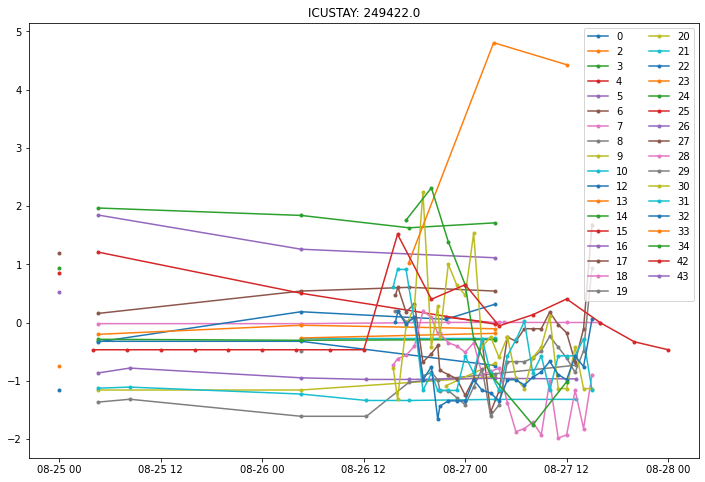

In [47]:
# Sample measurements for one admission by icustay_id
icustay_id = random.choice(train_df['episode'].values)
icustay_df = train_df[train_df['episode'] == icustay_id]

plt.figure(figsize=(12, 8))

for item_id, item_df in icustay_df.groupby('x0'):
    plt.plot(item_df['timestep'], item_df['x1'], '.-', label=item_id)
    
plt.title('ICUSTAY: %s' % icustay_id)
plt.legend(ncol=2)
plt.show()